## Setup


In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

import tensorflow as tf

# import by Zizhao
import random

## Download Data

In [0]:
#read data from google bucket
slides_num = ['002', '012', '023', '059', '075', '094', '101']
data_url = 'https://storage.googleapis.com/applied-deep-learning/Final_Project/'
slides_path = [('tumor_' + num + '.tif') for num in slides_num]
tumor_masks_path = [('tumor_' + num + '_mask.tif') for num in slides_num]

slides = []
tumor_masks = []

for sp in slides_path:
  if not os.path.exists(sp):
    slide_url = data_url+sp
    !curl -O $slide_url
  slides.append(open_slide(sp))
  
for tmp in tumor_masks_path:
  if not os.path.exists(tmp):
    mask_url = data_url+tmp
    !curl -O $mask_url
  tumor_masks.append(open_slide(tmp))

In [0]:
# Verify downsampling works as expected
for slide in slides:
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

In [0]:
# functions provided by Joshua Gordon
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

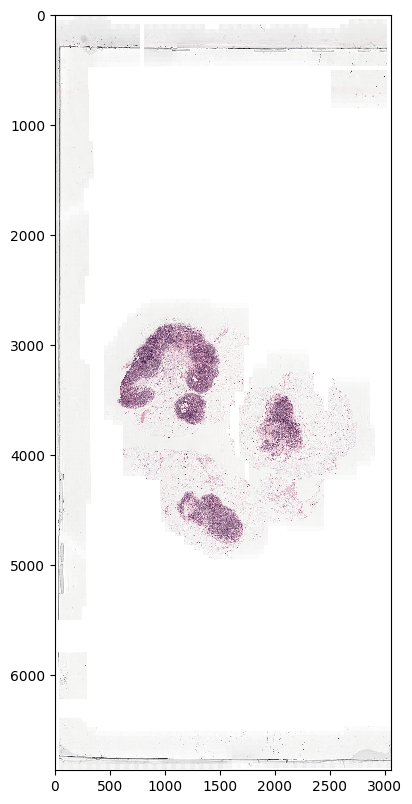

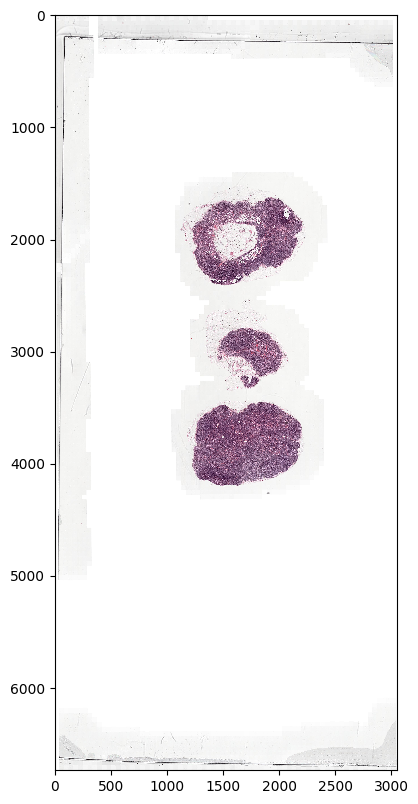

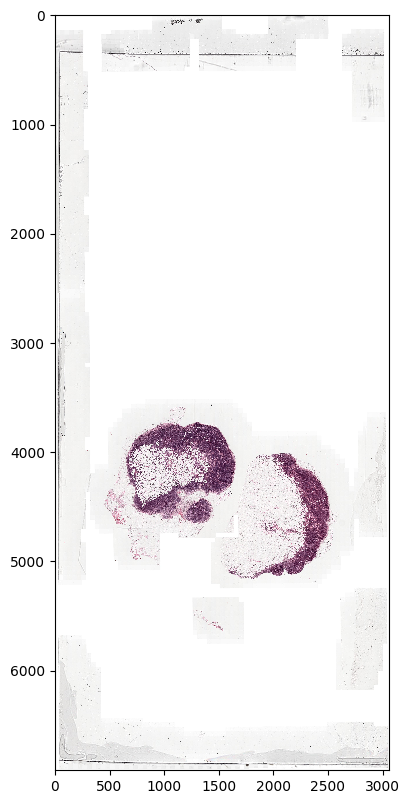

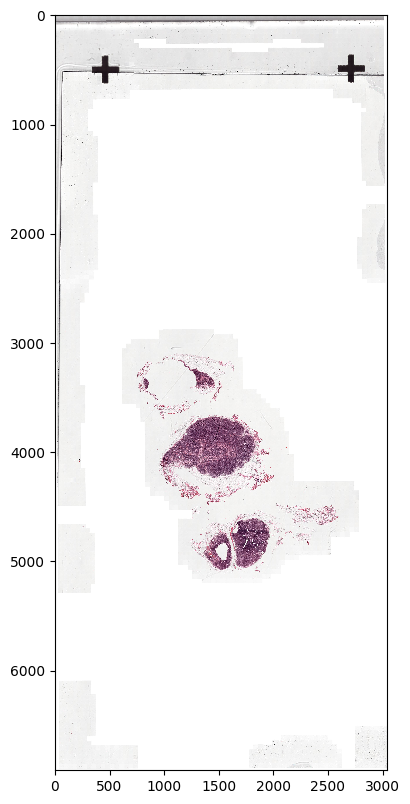

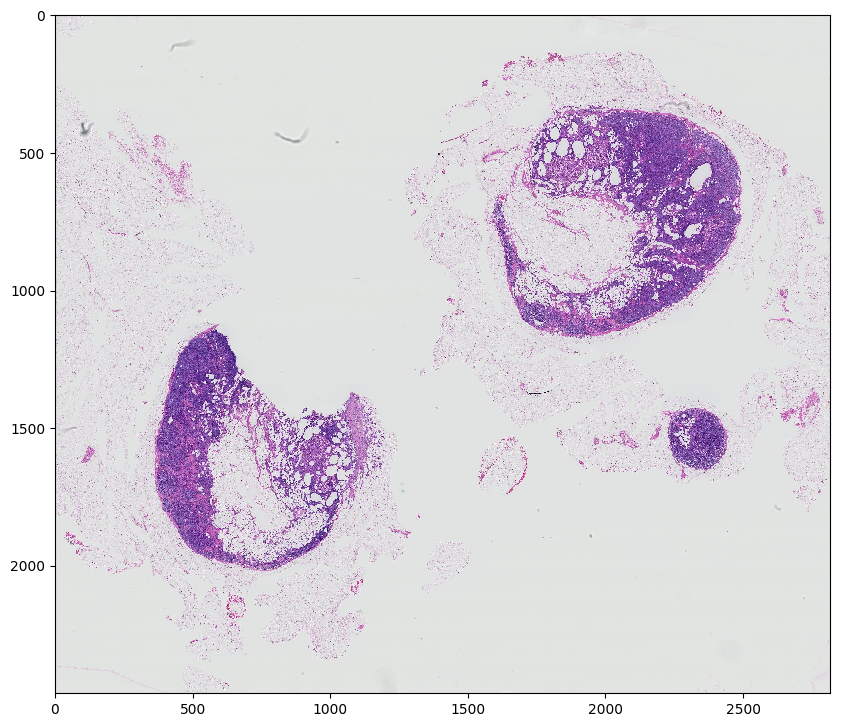

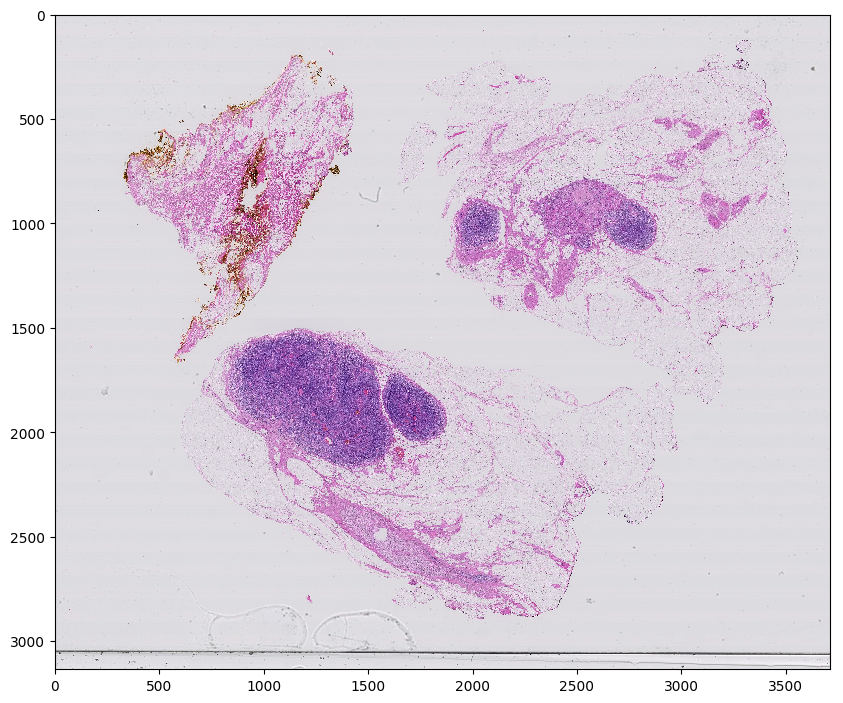

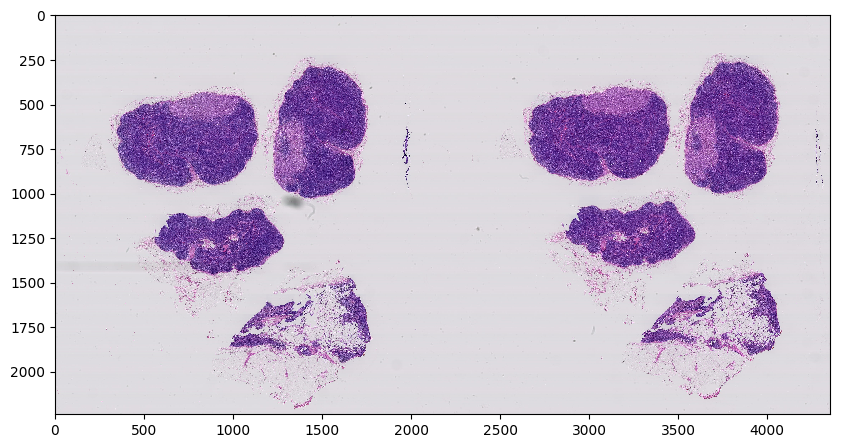

In [6]:
# Take a look at all slides at level 5
for slide in slides:
  slide_image = read_slide(slide, 
                           x=0, 
                           y=0, 
                           level=5, 
                           width=slide.level_dimensions[5][0], 
                           height=slide.level_dimensions[5][1])

  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image)

## Generating Dataset

In [0]:
def is_tumor_at_center(mask, center_size):
  patch_size = mask.shape[0]
  offset = (patch_size - center_size) // 2
  n_tumor_pixels = np.sum(mask[offset:offset + center_size, offset:offset + center_size])
  return n_tumor_pixels > 0

def get_patch(slide, tumor_mask, x, y, level, patch_size):
  # get patch centered at (x, y)
  
  x, y = int(x), int(y)
  half_patch_len = int(patch_size // 2 * slide.level_downsamples[level])
  
  slide_image = read_slide(slide, 
                           x - half_patch_len, 
                           y - half_patch_len, 
                           level, 
                           width=patch_size, 
                           height=patch_size)
  mask_image = read_slide(tumor_mask, 
                          x - half_patch_len, 
                          y - half_patch_len, 
                          level, 
                          width=patch_size, 
                          height=patch_size)
  mask_image = mask_image[:, :, 0]
  return slide_image, mask_image

def get_pixels(slide, tumor_mask, checking_level, half_patch_len):
    assert slide.level_dimensions[checking_level] == tumor_mask.level_dimensions[checking_level]
    slide_image = read_slide(slide,
                             x=0,
                             y=0,
                             level=checking_level,
                             width=slide.level_dimensions[checking_level][0],
                             height=slide.level_dimensions[checking_level][1])
    mask_image = read_slide(tumor_mask,
                            x=0,
                            y=0,
                            level=checking_level,
                            width=tumor_mask.level_dimensions[checking_level][0],
                            height=tumor_mask.level_dimensions[checking_level][1])
    mask_image = mask_image[:,:,0]
    
    slide_image_cropped = slide_image[half_patch_len:-half_patch_len, half_patch_len:-half_patch_len]
    mask_image_cropped  = mask_image[half_patch_len:-half_patch_len, half_patch_len:-half_patch_len]
    
    tissue_pixels = find_tissue_pixels(slide_image_cropped)
    tissue_mask = apply_mask(slide_image_cropped, tissue_pixels)
    
    # list of (x, y)
    normal_pixels = list(zip(*np.nonzero(tissue_mask[:, :, 0] - 255 * mask_image_cropped)))
    tumor_pixels = list(zip(*np.nonzero(mask_image_cropped)))
    
    return normal_pixels, tumor_pixels

def generate_dataset(slides, tumor_masks,
                     level1, level2,
                     n_data=2500,
                     patch_size=299, center_size=128):
  """
  inputs:
    slides:
      list of openslide files, of tissues
    tumor_masks:
      list of openslide files, of tumor masks
    level1, level2:
      int, zoom levels
    n_data:
      int, number of data points
    patch_size:
      int, size of the square patch extracted from slides
    center_size:
      int, size of the square center in the patch
  outputs:
    X1:
      np.array of patches at zoom level1
    X2:
      np.array of patches at zoom level2
    y:
      np.array of labels
  """
  assert n_data % 2 == 0
  
  # check which slides have tumors using tumor mask at a certain level
  checking_level = 5
  half_patch_len = patch_size // 2
  
  slide_has_normal_pixels = np.zeros(len(slides)).astype(bool)
  slide_has_tumor_pixels = np.zeros(len(tumor_masks)).astype(bool)
  
  for i, (slide, tumor_mask) in enumerate(zip(slides, tumor_masks)):
    normal_pixels, tumor_pixels = get_pixels(slide, tumor_mask, checking_level, half_patch_len)
    slide_has_normal_pixels[i] = normal_pixels is not None
    slide_has_tumor_pixels[i] = tumor_pixels is not None
  
  X1 = []
  X2 = []
  Y = []
  
  slide_has_normal_pixels = slide_has_normal_pixels.astype(float)
  slide_has_tumor_pixels = slide_has_tumor_pixels.astype(float)
  slide_normal_p = slide_has_normal_pixels / np.sum(slide_has_normal_pixels)
  slide_tumor_p = slide_has_tumor_pixels / np.sum(slide_has_tumor_pixels)
  
  
  n_normal_data_on_each_slide = np.random.multinomial(n_data / 2, slide_normal_p)
  n_tumor_data_on_each_slide = np.random.multinomial(n_data / 2, slide_tumor_p)

  for i, (slide, tumor_mask, n_normal_data, n_tumor_data) in \
    enumerate(zip(slides, tumor_masks, n_normal_data_on_each_slide, n_tumor_data_on_each_slide)):

    print("process slide {:>4d} / {}".format(i + 1, len(slides)))

    normal_pixels, tumor_pixels = get_pixels(slide, tumor_mask, checking_level, half_patch_len)
    normal_pixels = [(x + half_patch_len, y + half_patch_len) for y, x in normal_pixels]
    tumor_pixels = [(x + half_patch_len, y + half_patch_len) for y, x in tumor_pixels]
 
    for i in range(n_normal_data + n_tumor_data):

      choose_tumor = i < n_normal_data
      chosen_pixels = tumor_pixels if choose_tumor else normal_pixels

      # randomly choose one patch from the chosen slide
      found_patch = False
      while not found_patch:
        x, y = random.choice(chosen_pixels)
        x = x * slide.level_downsamples[checking_level]
        y = y * slide.level_downsamples[checking_level]

        patch_image1, patch_mask = get_patch(slide, tumor_mask, x, y, level1, patch_size)

        exist_tumor = is_tumor_at_center(patch_mask, center_size)

        tissue_pixels = find_tissue_pixels(patch_image1)
        tissue_percentage = float(len(list(tissue_pixels))) / patch_size**2 * 100

        if tissue_percentage > 50 and exist_tumor == choose_tumor:
          found_patch = True

          patch_image2, _ = get_patch(slide, tumor_mask, x, y, level2, patch_size)
          X1.append(patch_image1)
          X2.append(patch_image2)
          Y.append(int(choose_tumor))
        
  X1, X2, Y = np.array(X1), np.array(X2), np.array(Y)
  return X1, X2, Y

In [8]:
level1 = 4
level2 = 5
X1, X2, y = generate_dataset(slides[4:5], tumor_masks[4:5], level1, level2, n_data=4)

process slide    1 / 1


0


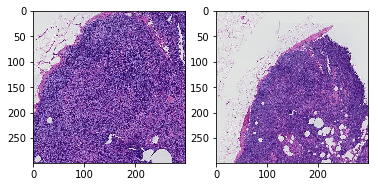

In [9]:
i = 3
x1, x2, label = X1[i], X2[i], y[i]
plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.subplot(1, 2, 2)
plt.imshow(x2)
print(label)### Save Data



## Save Data to Google Drive

In [10]:
!pip install Pillow

In [12]:
#get access to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from PIL import Image


def upload_images(X1, X2, i):
  """
  upload images to google drive
  Directories needed on google drive before running this cell:
  My Drive/ADL_Project/slides/normal
  My Drive/ADL_Project/slides/tumor
  My Drive/ADL_Project/masks/normal
  My Drive/ADL_Project/masks/tumor
  """
  

  im_X1 = Image.fromarray(X1)
  im_X2 = Image.fromarray(X2)

  local_path_X1 = '/content/gdrive/My Drive/ADL_Project/slides'
  local_path_X2 = '/content/gdrive/My Drive/ADL_Project/masks'
  
  if y[i] == 0:
    local_path_X1 += '/normal'
    local_path_X2 += '/normal'
  else:
    local_path_X1 += '/tumor'
    local_path_X2 += '/tumor'
    
    
  local_file_name_X1 = 'X1_' + str(i) + '.jpg'
  local_file_name_X2 = 'X2_' + str(i) + '.jpg'
  
  
  im_X1.dir = os.path.join(local_path_X1, local_file_name_X1)
  im_X2.dir = os.path.join(local_path_X2, local_file_name_X1)

  im_X1.save(im_X1.dir)
  im_X2.save(im_X2.dir)
  
  print('Uploaded ' + local_file_name_X1 + ' to ' + im_X1.dir)
  print('Uploaded ' + local_file_name_X2 + ' to ' + im_X2.dir)

In [14]:
#Data augmentation
from keras.preprocessing.image import ImageDataGenerator
def get_train_generator(slides_dir='/content/gdrive/My Drive/ADL_Project/slides',
                        masks_dir='/content/gdrive/My Drive/ADL_Project/masks'):
  """
  input: slides_dir: directory of slides
         masks_dir: directory of masks
         default upload from google drive
         
         
  
  """
  data_gen_args = dict(featurewise_center=True,
                       featurewise_std_normalization=True,
                       rotation_range=90,
                       width_shift_range=0.1,
                       height_shift_range=0.1,
                       zoom_range=0.2)

  slide_datagen = ImageDataGenerator(**data_gen_args)
  mask_datagen = ImageDataGenerator(**data_gen_args)

  seed = 4995

  slide_generator = slide_datagen.flow_from_directory(slides_dir,
                                                     class_mode=None,
                                                     seed=seed)

  mask_generator = mask_datagen.flow_from_directory(masks_dir,
                                                   class_mode=None,
                                                   seed=seed)

  train_generator = zip(slide_generator, mask_generator)

  return train_generator





Using TensorFlow backend.


In [15]:
upload_images(x1, x2, 2)

Uploaded X1_2.jpg to /content/gdrive/My Drive/ADL_Project/slides/tumor/X1_2.jpg
Uploaded X2_2.jpg to /content/gdrive/My Drive/ADL_Project/masks/tumor/X1_2.jpg


In [0]:
train_generator = get_train_generator()

Found 1 images belonging to 2 classes.
Found 1 images belonging to 2 classes.


/usr/local/lib/python2.7/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python2.7/dist-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [0]:
train_images = X1
train_labels = y
test_images = X2
test_labels = y

In [15]:
#convert images to np arrays
X_train = np.asarray(train_images)
y_train = np.asarray(train_labels)

X_test = np.asarray(test_images)
y_test= np.asarray(test_labels)

assert X_train.shape[0] == len(y_train)
assert X_test.shape[0] == len(y_test)

print(X_train.shape, X_test.shape)


((4, 299, 299, 3), (4, 299, 299, 3))


In [0]:
del train_images, train_labels, test_images, test_labels

In [0]:
#save np arrays to google drive
level=4
X_train_name = 'X_train_' + str(level) + '.npy'
y_train_name = 'y_train_' + str(level) + '.npy'
X_test_name = 'X_test_' + str(level) + '.npy'
y_test_name = 'y_test_' + str(level) + '.npy'

np.save(X_train_name, X_train)
np.save(y_train_name, y_train)
np.save(X_test_name, X_test)
np.save(y_test_name, y_test)

########TODO: upload to Google Drive


In [0]:
##split train and validaition set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2,
                                                  random_state=4995, stratify=y_train,
                                                 shuffle=True)


In [0]:
del X_train, y_train

In [22]:
patch_size = 299
incept_conv_base = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet',
                                                                 include_top=False,
                                                                 input_shape=(patch_size, patch_size, 3))

model = tf.keras.Sequential([
    incept_conv_base,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
87924736/87910968 [==============================] - 2s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               33554688  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 55,357,7

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [0]:
import time

In [27]:
#####early stoping########

BATCH_SIZE=4
EPOCHS=2
#time execution 
start_time = time.time()
#history = model.fit_generator(train_generator, steps_per_epoch=32*9,
#                             epochs=50, 
#                             validation_data=val_generator,
#                             validation_steps=50)

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                   verbose=2, validation_data = (X_test, y_test))


train_time = time.time() - start_time

print('Time: %.2f' % train_time)

Train on 4 samples, validate on 4 samples
Epoch 1/2
 - 0s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/2
 - 0s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Time: 0.52


In [0]:
##save weights and upload to google drive
mweights_name = str(model) + '_weights.h5'
model.save(mweights_name)

uploaded_w = drive.CreateFile({'title': mweights_name})
uploaded.SetContentFile(mweights_name)
uploaded.Upload()



In [0]:
def plot_history(train_hist, key=['acc', 'loss']):
  fig, axes = plt.subplots(1, 2, figsize = (20, 10))
  

## Li's Patch Reading

In [0]:
patches = []
tumor_patches = []
PATCH_SIZE = 80
for k,slide in enumerate(slides):
  mask_image = read_slide(tumor_masks[k],x=0,y=0,level = 7, width=tumor_masks[k].level_dimensions[7][0], height=tumor_masks[k].level_dimensions[7][1])

  if np.count_nonzero(mask_image) > 0:  #checks if there actually is tumor in the slide
    
    for j in range(0,slide.level_dimensions[7][1],PATCH_SIZE):
      for i in range(0,slide.level_dimensions[7][0],PATCH_SIZE):
        patch = read_slide(slide,i*128,j*128,level = 7, width = PATCH_SIZE,height = PATCH_SIZE) #patch from slide
        mask_patch = read_slide(tumor_masks[k],i*128,j*128,level = 7, width = PATCH_SIZE,height = PATCH_SIZE)  #corresponding patch from mask
        tumor_patch = mask_patch[:,:,0] #take only one channel of mask
        tissue_pixels = find_tissue_pixels(patch) #find how many tissue pixels are there slide patch
        tissue_pixels = list(tissue_pixels)
        percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[0]) * 100 #percentage tissue in the patch
        if percent_tissue > 0:  #check if percent tissue is more than 10, if yes, then append both the slide patch and mask patch
          patches.append(patch)
          tumor_patches.append(tumor_patch)

In [0]:
#check if the number of slide patches and the number of patches from the masks correspond
assert len(patches) == len(tumor_patches)

In [0]:
#convert both lists to numpy arrays

patches = np.array(patches)
tumor_patches = np.array(tumor_patches)

#assigning labels to each patch: 1 if there is at least one non-zero entry in the corresponding mask patch, 0 if not. 

labels = []

for array in tumor_patches:
  if np.count_nonzero(array) > 0:
    labels.append(1)
  else :
    labels.append(0)
    
#converting to numpy array
labels = np.array(labels)


#checking the indices where the labels are 1
np.where(labels == 1)

(array([ 48, 155, 261, 262, 280, 293, 393, 460, 461, 483, 484, 492, 493,
        545, 546, 557, 558, 565, 644, 645, 646, 650, 651, 652, 658, 659,
        666, 667, 672, 673, 680, 686, 693, 694]),)